In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import seaborn as sns
# from pyDOE import lhs
import random
import os
import time

plt.rcParams.update({'font.size':18})

In [2]:
def seed_torch(seed=1024):
    #     random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [3]:
domain = (0, 1, -1, 1)
tmin, tmax, xmin, xmax = domain
mlp_layers = [2] + [50]*5 + [1]
# adam_iters = 40000
adam_iters = 20000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = r'./model'
train_info_path = r'./'
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [4]:
class Dataset:
    def __init__(self, domain):
        self.domain = domain

    def train_data(self, verbose=None):
        tmin, tmax, xmin, xmax = self.domain
        # 内部点采样
        t_res = np.linspace(tmin, tmax, 50)
        x_res = np.linspace(xmin, xmax, 80)
        X_res = self.sample_xy(t_res, x_res)
        
        X_bcs = np.array([]).reshape((-1, 2))
        X_bcs_l = np.concatenate([X_bcs, self.sample_xy(np.linspace(tmin, tmax, 50), np.array([xmin]))], axis=0)
        X_bcs_u = np.concatenate([X_bcs, self.sample_xy(np.linspace(tmin, tmax, 50), np.array([xmax]))], axis=0)
        
        X_ics =self.sample_xy(np.array([tmin]), np.linspace(xmin, xmax, 100))
        # X_ics = np.concatenate([X_ics, self.sample_xy(np.array([tmin]), np.linspace(xmin,xmax,100))], axis=0)
        
        u_ics = self.u_ics_sol(X_ics)

        return X_res, X_bcs_l, X_bcs_u, X_ics, u_ics


    def sample_xy(self, x, y):
        xx, yy = np.meshgrid(x, y)
        X = np.concatenate([xx.reshape((-1, 1)), yy.reshape((-1, 1))], axis=1)
        return X
    
    def u_ics_sol(self, X):
        return X[:, [1]]**2 * np.sin(2*np.pi * X[:, [1]])
    
dataset = Dataset(domain)
# 内部点与边界点
X_res, X_bcs_l, X_bcs_u, X_ics, u_ics = dataset.train_data()
print(X_res.shape,X_bcs_l.shape, X_bcs_u.shape, X_ics.shape, u_ics.shape)

(4000, 2) (50, 2) (50, 2) (100, 2) (100, 1)


## DNN

In [5]:
class MLP(nn.Module):
    def __init__(self, mlp_layers):
        super(MLP, self).__init__()
        self.model = nn.Sequential()
        for i in range(len(mlp_layers) - 2):
            self.model.add_module(f'fc{i + 1}', nn.Linear(mlp_layers[i], mlp_layers[i + 1], bias=True))
            self.model.add_module(f'act{i + 1}', nn.Tanh())
        self.model.add_module(f'fc{len(mlp_layers) - 1})', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))

    def forward(self, X):
        return self.model(X)

mlp = MLP(mlp_layers)
mlp

MLP(
  (model): Sequential(
    (fc1): Linear(in_features=2, out_features=50, bias=True)
    (act1): Tanh()
    (fc2): Linear(in_features=50, out_features=50, bias=True)
    (act2): Tanh()
    (fc3): Linear(in_features=50, out_features=50, bias=True)
    (act3): Tanh()
    (fc4): Linear(in_features=50, out_features=50, bias=True)
    (act4): Tanh()
    (fc5): Linear(in_features=50, out_features=50, bias=True)
    (act5): Tanh()
    (fc6)): Linear(in_features=50, out_features=1, bias=False)
  )
)

## 主干网络

In [6]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

In [7]:
class PINN(nn.Module):
    def __init__(self, backbone, mu=None, sigma=None):
        super(PINN, self).__init__()
        self.backbone = backbone

    def forward(self, X_res, X_bcs_l, X_bcs_u, X_ics, u_ics):
        
        loss_res = torch.mean(self.net_f(X_res) ** 2)
        loss_ics = torch.mean((self.net_u(X_ics)-u_ics) ** 2)
        loss_bcs = torch.mean((self.net_u(X_bcs_l)-self.net_u(X_bcs_u)) ** 2)
        loss_bcs_t = torch.mean((self.net_u_x(X_bcs_l)-self.net_u_x(X_bcs_u)) ** 2)

        return loss_res, loss_ics,loss_bcs,loss_bcs_t

    def net_u(self, X):
        return self.backbone(X)
    
    def net_u_x(self,X):
        X.requires_grad_(True)
        u = self.net_u(X)
        
        # 求梯度
        grad_u = grad(u, X)[0]
        u_x = grad_u[:, [1]]
        return u_x

    def net_f(self, X):
        X.requires_grad_(True)
        u = self.net_u(X)
#         print(u.shape)
        # 求梯度
        grad_u = grad(u, X)[0]
        u_t = grad_u[:, [0]]
        u_x = grad_u[:, [1]]
        u_tt = grad(u_t, X)[0][:, [0]]
        u_xx = grad(u_x, X)[0][:, [1]]
        
        gamma1 = 0.0001
        gamma2 = 1
        
        f = u_t - gamma1*u_xx + gamma2*u**3 - gamma2*u
        return f  

pinn = PINN(mlp)

## Adam

In [8]:
dataset = Dataset(domain)
X_res, X_bcs_l, X_bcs_u, X_ics, u_ics = dataset.train_data()

X_res = torch.from_numpy(X_res).float().to(device)
X_bcs_l = torch.from_numpy(X_bcs_l).float().to(device)
X_bcs_u = torch.from_numpy(X_bcs_u).float().to(device)
X_ics = torch.from_numpy(X_ics).float().to(device)
u_ics = torch.from_numpy(u_ics).float().to(device)

mu = X_res.mean(dim=0)
sigma = X_res.std(dim=0)  # 求样本标准差

backbone = MLP(mlp_layers)  # 主干网络
pinn = PINN(backbone, mu, sigma).to(device)

optimizer_adam = optim.Adam(pinn.backbone.parameters(), lr=1e-3)

lr_sche = optim.lr_scheduler.ExponentialLR(optimizer_adam, gamma=0.8)  # 指数衰减学习率

logger = {
    "loss": [], 
    "loss_res": [],
    "loss_ics": [],
    "loss_bcs": [],
    "loss_bcs_t": [],
    "iter": [],
    "mu": mu,
    "sigma": sigma
}
best_loss = 1e9

# 训练
start_time = time.time()
for it in range(adam_iters):
    pinn.train()
    pinn.zero_grad()
    
    loss_res, loss_ics, loss_bcs, loss_bcs_t = pinn(X_res, X_bcs_l, X_bcs_u, X_ics, u_ics)
    loss = 100*loss_res + 100*loss_ics + loss_bcs + loss_bcs_t
    
    loss.backward()
    optimizer_adam.step()
    
    if (it + 1) % 100 == 0:
        # 保存loss信息
        pinn.train(False)
        loss_res_valid, loss_ics_valid, loss_bcs_valid, loss_bcs_t_valid = pinn(X_res, X_bcs_l, X_bcs_u, X_ics, u_ics)
        loss_valid = loss_res_valid + loss_ics_valid + loss_bcs_valid + loss_bcs_t_valid
        
        logger["loss"].append(loss_valid.item())
        logger["loss_res"].append(loss_res_valid.item())
        logger["loss_ics"].append(loss_ics_valid.item())
        logger["loss_bcs"].append(loss_bcs_valid.item())
        logger["loss_bcs_t"].append(loss_bcs_t_valid.item())
        logger["iter"].append(it+1)
        
        
        # 保存训练loss最低的模型
        if loss_valid.item() < best_loss:
            model_state = {'iter': it+1, 'backbone_state': pinn.backbone.state_dict()}
            torch.save(model_state, os.path.join(model_path, 'pinn_adam.pth'))
            best_loss = loss_valid.item()
        
        if (it + 1) % 500 == 0:
            # 保存并打印训练日志
            info = f'Iter # {it+1:6d}/{adam_iters}\t' + \
                f'loss:{loss.item():.2e}, loss_r:{loss_res.item():.2e}, loss_i:{loss_ics.item():.2e} , loss_b:{loss_bcs.item():.2e}, loss_b_t:{loss_bcs_t.item():.2e}  ' + \
                f'Valid # loss:{loss_valid.item():.2e}, loss_r:{loss_res_valid.item():.2e}, loss_i:{loss_ics_valid.item():.2e}, loss_b:{loss_bcs_valid.item():.2e}, loss_b_t:{loss_bcs_t_valid.item():.2e}'
            with open(train_info_path + 'train_info.txt', 'a') as f:
                f.write(info + '\n')
            print(info)
            
        # 衰减学习率
        if (it + 1) % 4000 == 0:
            lr_sche.step()
        

Iter #    500/20000	loss:7.69e+00, loss_r:8.19e-03, loss_i:6.86e-02 , loss_b:8.21e-03, loss_b_t:3.43e-03  Valid # loss:8.80e-02, loss_r:7.93e-03, loss_i:6.88e-02, loss_b:7.82e-03, loss_b_t:3.49e-03
Iter #   1000/20000	loss:7.63e+00, loss_r:6.88e-03, loss_i:6.93e-02 , loss_b:1.03e-02, loss_b_t:4.03e-03  Valid # loss:9.42e-02, loss_r:9.45e-03, loss_i:6.71e-02, loss_b:1.39e-02, loss_b_t:3.78e-03
Iter #   1500/20000	loss:7.33e+00, loss_r:1.05e-02, loss_i:6.18e-02 , loss_b:9.19e-02, loss_b_t:9.56e-03  Valid # loss:1.77e-01, loss_r:1.08e-02, loss_i:6.15e-02, loss_b:9.50e-02, loss_b_t:9.72e-03
Iter #   2000/20000	loss:6.88e+00, loss_r:1.06e-02, loss_i:5.54e-02 , loss_b:2.76e-01, loss_b_t:4.73e-03  Valid # loss:3.36e-01, loss_r:9.12e-03, loss_i:5.72e-02, loss_b:2.64e-01, loss_b_t:5.07e-03
Iter #   2500/20000	loss:5.22e+00, loss_r:6.92e-03, loss_i:3.82e-02 , loss_b:6.81e-01, loss_b_t:2.57e-02  Valid # loss:7.37e-01, loss_r:5.45e-03, loss_i:3.98e-02, loss_b:6.66e-01, loss_b_t:2.60e-02
Iter #   3

In [9]:
np.save("./logger.npy", logger)

In [10]:
logger = np.load("./logger.npy", allow_pickle=True).item()
k = 2
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(9, 7))
    plt.subplot(111)
    # plt.plot(logger["iter"][::k], logger["loss"][::k], label=r"$L$")
    plt.plot(logger["iter"][::k], logger["loss_res"][::k], label=r"$\mathcal{L}_{r}$", linewidth=3)
    plt.plot(logger["iter"][::k], logger["loss_ics"][::k], label=r"$\mathcal{L}_{ics}$", linewidth=3)
    plt.legend()
    plt.xticks([0, 5000, 10000, 15000, 20000])
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.savefig('loss.png', dpi=100)
    plt.show()

UnpicklingError: STACK_GLOBAL requires str

In [11]:
t = np.linspace(tmin, tmax, 100)
x = np.linspace(xmin, xmax, 100)
tt, xx = np.meshgrid(t, x)
X = np.concatenate([tt.reshape((-1, 1)), xx.reshape((-1, 1))], axis=1)

X = torch.from_numpy(X).float().to(device)

u_pred = pinn.net_u(X).detach().cpu().numpy()

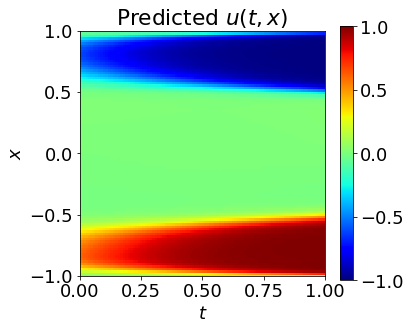

In [13]:
fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1)
plt.pcolor(tt, xx, u_pred.reshape(xx.shape), cmap='jet', vmin = -1, vmax = 1)
plt.colorbar()
# plt.clim([-1., 1.])
plt.xlabel('$t$')
plt.ylabel('$x$')
ax.set_xlim([0, 1])
ax.set_ylim([-1, 1])
ax.set_xticks(np.linspace(0, 1, 5))
ax.set_yticks(np.linspace(-1, 1, 5))
plt.title(r'Predicted $u(t,x)$')
ax.set_aspect(1./ax.get_data_ratio())
plt.tight_layout()
plt.savefig('AC_pred_viridis.png', dpi=100)